# 第４章 TensorFlowでRNN

今までのニューラルネットでは時系列を考慮できなかった。時系列情報を考慮するケースとして自然言語処理がある。    


## 4.1 Recurrent Neural Network

時系列情報とは入力や出力の値だけでなく、その順序が重要になる情報。    
「私/は/犬/が/好き/です/。」

- tf.nn.rnn_cellパッケージのrnn_cell    
- tf.nnパッケージのhogehoge_rnn    
    
tf.nn.rnn_cell.BasicRNNCell()は普通のRNNで入力 [バッチサイズ、ユニット数]の2階テンソルを受け取り、同じ2階テンソルを返す。    

tf.nn.rnn_cell.BasicLSTMCell()はLSTM。    

hogehoge_rnnは入力が全時刻の入力Xとrnn_cellで、全時刻の出力Yと最後の中間層状態を返す。    
rnn_cellが単一時間の制御で、hogehoge_rnnは全体制御をする違いがある。    

hogehoge_rnnはstatic_rnnとdynamic_rnnに大別できる。    
static_rnnは時間長が固定になり、1度モデルを作ると変更できない。    
dynamic_rnnは何時間ステップ展開するか動的にできる。

TensorFlowのRNNを追ってみる    
https://drive.google.com/file/d/1D2A47tXUlx8qlfIVoW4k3U8dTxEEA484/view?usp=sharing    
or    
https://github.com/miyamotok0105/machine-learning-handson/blob/master/tensorflow1.7.0/TensorFlow%E3%81%AERNN%E3%82%92%E8%BF%BD%E3%81%A3%E3%81%A6%E3%81%BF%E3%82%8B.ipynb

## 4.2 TensorFlowにおけるRNN実装

- rnn_cellについて

In [14]:
import tensorflow as tf

seq_length = 6
data_dim =4
hidden_dim = 12
X = tf.placeholder(tf.int32, [None, seq_length])
Y = tf.placeholder(tf.int32, [None])
keep_prob = tf.placeholder(tf.float32)

X_one_hot = tf.one_hot(X, data_dim)
Y_one_hot = tf.one_hot(Y, 2)

def lstm_cell():
    lstm = tf.contrib.rnn.BasicLSTMCell(hidden_dim, state_is_tuple=True)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    return drop

#3層のLSTM
multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(3)], state_is_tuple=True)
outputs1, _states = tf.nn.dynamic_rnn(multi_cells, X_one_hot, dtype=tf.float32)

print(outputs1.shape)

(?, 6, 12)


In [13]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

n_steps = 2
n_inputs = 4
n_neurons = 6

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

#中間層ユニット数20のRNN
cell1 = tf.nn.rnn_cell.BasicRNNCell(num_units=20)
outputs, states = tf.nn.dynamic_rnn(cell1, X, dtype=tf.float32)

init = tf.global_variables_initializer()

X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2, 3], [15, 14, 13, 12]], 
        [[4, 5, 6, 7], [0, 0, 0, 0]], 
        [[8, 9, 10, 11], [8, 7, 6, 5]], 
        [[12, 13, 14, 15], [4, 3, 2, 1]], 
    ])
print(X_batch.shape)
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print(outputs_val.shape)

(4, 2, 4)
(4, 2, 20)


In [15]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

n_steps = 2
n_inputs = 4
n_neurons = 6

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

#中間層ユニット数20のRNN
cell1 = tf.nn.rnn_cell.BasicRNNCell(num_units=20)
#LSTM層
cell2 = tf.nn.rnn_cell.LSTMCell(num_units=20, use_peepholes=True)
#ドロップアウトを入れる
cell2 = tf.nn.rnn_cell.DropoutWrapper(cell2, output_keep_prob=0.6)
#RNNとLSTM
cell = tf.nn.rnn_cell.MultiRNNCell(cells=[cell1, cell2])

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2, 3], [15, 14, 13, 12]], 
        [[4, 5, 6, 7], [0, 0, 0, 0]], 
        [[8, 9, 10, 11], [8, 7, 6, 5]], 
        [[12, 13, 14, 15], [4, 3, 2, 1]], 
    ])
print(X_batch.shape)
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print(outputs_val.shape)

(4, 2, 4)
(4, 2, 20)


# Sequential MNIST

MNISTの分類問題をRNNで実装。MNISTは[高さ、幅、チャンネル]の３階テンソルでチャンネルが１なので2階テンソルとして扱うこともできる。    
１行目をt=1の入力、2行目をt=2とする。28時刻の時系列問題とする。    
精度が高いわけではないが、RNNの良い教材になる。

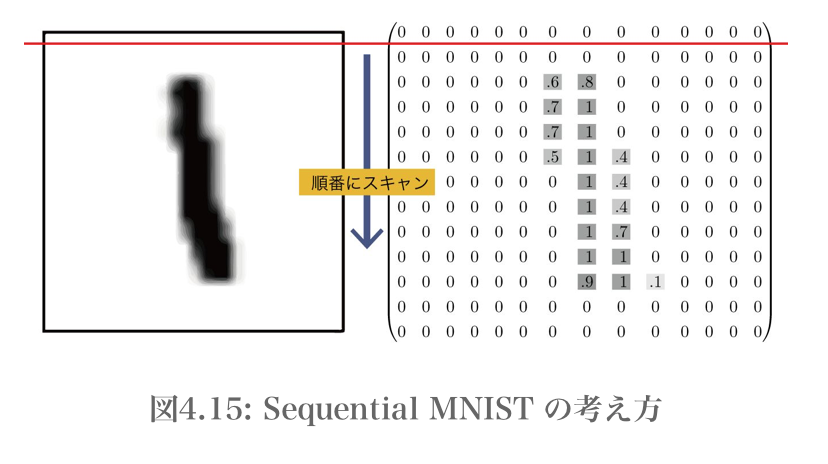

In [3]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

#mnistデータを格納したオブジェクトを呼び出す
mnist = input_data.read_data_sets("data/", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [4]:
"""モデル構築開始"""
#入力データ整形
num_seq = 28
num_input = 28

In [5]:
x = tf.placeholder(tf.float32, [None, 784])
#(バッチサイズ,高さ, 幅)の2階テンソルに変換
input = tf.reshape(x, [-1, num_seq, num_input])

- tf.nn.rnn_cellについて    
型を決めた後にラッピングしていく

In [6]:
#ユニット数128個のLSTMセル
#三段に積む
stacked_cells = []
for i in range(2):
    stacked_cells.append(tf.nn.rnn_cell.LSTMCell(num_units=128))
cell = tf.nn.rnn_cell.MultiRNNCell(cells=stacked_cells)
#dynamic_rnnによる時間展開
outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=input, dtype=tf.float32)

In [7]:
#3階テンソルを2階テンソルのリストに変換
outputs_list = tf.unstack(outputs, axis=1)
#最終時系列情報を取得
last_output = outputs_list[-1]

w = tf.Variable(tf.truncated_normal([128,10], stddev=0.1))
b = tf.Variable(tf.zeros([10]))

out = tf.nn.softmax(tf.matmul(last_output, w ) + b)

In [8]:
#正解データの型を定義
y = tf.placeholder(tf.float32, [None, 10])
#誤差関数（クロスエントロピー）
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out), axis=[1]))

In [9]:
#訓練
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

#評価
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [10]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    #テストデータをロード
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for i in range(1000):
        step = i+1
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})

        #10階ごとに精度を検証
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))
            

Step 100: accuracy = 0.44
Step 200: accuracy = 0.59
Step 300: accuracy = 0.70
Step 400: accuracy = 0.80
Step 500: accuracy = 0.83
Step 600: accuracy = 0.87
Step 700: accuracy = 0.90
Step 800: accuracy = 0.91
Step 900: accuracy = 0.93
Step 1000: accuracy = 0.93


# MeCab

https://qiita.com/SUZUKI_Masaya/items/1e31b65b92640e045a99    
-F, --node-format	通常の形態素の出力フォーマット    
-U, --unk-format	未知語形態素の出力フォーマット    
-B, --bos-format	Headerの出力フォーマット    
-E, --eos-format	Footerの出力フォーマット    


In [10]:
!echo "本日は晴天なり。" | mecab -F "%m\n"

本日
は
晴天
なり
。
EOS


In [11]:
!echo "本日は晴天なり。" | mecab -U "%m\n"

本日	名詞,副詞可能,*,*,*,*,本日,ホンジツ,ホンジツ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
晴天	名詞,一般,*,*,*,*,晴天,セイテン,セイテン
なり	助動詞,*,*,*,文語・ナリ,基本形,なり,ナリ,ナリ
。	記号,句点,*,*,*,*,。,。,。
EOS


MeCabをブーストさせよう      
https://qiita.com/knknkn1162/items/8c12f42dd167aae01c02    

# natto-py

https://qiita.com/buruzaemon/items/975027cea6371b2c5ec3    
インスタンスを取得    

In [6]:
from natto import MeCab

nm = MeCab()

print(nm)

<natto.mecab.MeCab model=<cdata 'mecab_model_t *' 0x7f9d5885ef00>, tagger=<cdata 'mecab_t *' 0x7f9d588df000>, lattice=<cdata 'mecab_lattice_t *' 0x7f9d58adae90>, libpath="/usr/local/Cellar/mecab/0.996/lib/libmecab.dylib", options={}, dicts=[<natto.dictionary.DictionaryInfo dictionary=<cdata 'mecab_dictionary_info_t *' 0x7f9d58c19cf0>, filepath="/usr/local/lib/mecab/dic/ipadic/sys.dic", charset=utf8, type=0>], version=0.996>


parseを使う

In [7]:
from natto import MeCab
nm = MeCab()
text = "ピンチの時には必ずヒーローが現れる。"
print(nm.parse(text))

ピンチ	名詞,一般,*,*,*,*,ピンチ,ピンチ,ピンチ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
時	名詞,非自立,副詞可能,*,*,*,時,トキ,トキ
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
必ず	副詞,助詞類接続,*,*,*,*,必ず,カナラズ,カナラズ
ヒーロー	名詞,一般,*,*,*,*,ヒーロー,ヒーロー,ヒーロー
が	助詞,格助詞,一般,*,*,*,が,ガ,ガ
現れる	動詞,自立,*,*,一段,基本形,現れる,アラワレル,アラワレル
。	記号,句点,*,*,*,*,。,。,。
EOS


In [ ]:
with MeCab('-F%m,%f[0],%h,%f[8]') as nm:
    for n in nm.parse(text, as_nodes=True):
        print(n.feature)

# 4.5 TensorFlowでWord2Vec

データ取得。
word2vec/dataフォルダにテキストファイルをダウンロードする。    
https://www.aozora.gr.jp/cards/000020/card2569.html#download    

In [3]:
# -*- coding: utf-8 -*-

import glob
import re
import collections
import random

import numpy as np
from natto import MeCab

class DataSet(object):

    def __init__(self, data_dir, max_vocab):

        #全データセットのファイルパスを取得
        file_pathes = []
        for file_path in glob.glob(data_dir+'*'):
            file_pathes.append(file_path)

        #ファイルを読み込み
        row_documents = [self._read_docment(file_path) for file_path in file_pathes]
        #必要な部分だけ抽出
        documents = [self._preprocessing(document) for document in row_documents]
        #形態素解析
        splited_documents = [self._morphological(document) for document in documents]

        words = []
        for word_list in splited_documents:
            words.extend(word_list)
        
        #データセット作成
        self.id_sequence, self.word_frequency, self.w_to_id, self.id_to_w = self._build_data_sets(words, max_vocab)
        print('Most common words (+UNK)', self.word_frequency[:5])
        print('Sample data.')
        print(self.id_sequence[:10])
        print([self.id_to_w[i] for i in self.id_sequence[:10]])
        self.data_index = 0


    #ファイルの読み込み
    def _read_docment(self, file_path):
        with open(file_path, 'r', encoding='sjis') as f:
            return f.read()

    #ヘッダなどの不要データを前処理。必要な部分だけを返す。
    def _preprocessing(self, document):

        lines = document.splitlines()
        processed_line = []

        horizontal_count = 0

        for line in lines:

            #ヘッダーは読み飛ばす
            if horizontal_count < 2:
                if line.startswith('-------'):
                    horizontal_count += 1
                continue
            #フッターに入る行になったらそれ以降は無視
            if line.startswith('底本：'):
                break

            line = re.sub(r'《.*》', '', line) #ルビを除去
            line = re.sub(r'［.*］', '', line) #脚注を除去
            line =re.sub(r'[!-~]', '', line) #半角記号を除去
            line =re.sub(r'[︰-＠]', '', line) #全角記号を除去
            line = re.sub('｜', '', line) # 脚注の始まりを除去

            processed_line.append(line)

        return ''.join(processed_line)

    #形態素解析
    def _morphological(self, document):

        word_list = []
        #MeCabの形態素解析結果のフォーマット
        with MeCab('-F%f[0],%f[1],%f[6]') as mcb:
            for token in mcb.parse(document, as_nodes=True):
                features = token.feature.split(',')
                #名詞（一般）動詞（自立）、形容詞（自立）以外は除外
                if features[0] == '名詞' and features[1] == '一般' and features[2] != '':
                    word_list.append(features[2])
                if features[0] == '動詞' and features[1] == '自立' and features[2] != '':
                    word_list.append(features[2])
                if features[0] == '形容詞' and features[1] == '自立' and features[2] != '':
                    word_list.append(features[2])
        return word_list

    #辞書作成
    def _build_data_sets(self, words, max_vocab):

        #単語出現回数を解析。出現数が少ないたんをUnknown wordとしてひとくくりに扱う
        word_frequency = [['UNW', -1]]
        word_frequency.extend(collections.Counter(words).most_common(max_vocab - 1))
        #単語=>IDの辞書
        w_to_id = dict()
        for word, _ in word_frequency:
            w_to_id[word] = len(w_to_id)
        #形態素解析した文章を単語IDの並びに変換
        id_sequence = list()
        unw_count = 0
        for word in words:
            #UNK処理
            if word in w_to_id:
                index = w_to_id[word]
            else:
                index = 0
                unw_count += 1
            id_sequence.append(index)
        word_frequency[0][1] = unw_count
        #単語ID=>単語の辞書
        id_to_w = dict(zip(w_to_id.values(), w_to_id.keys()))
        return id_sequence, word_frequency, w_to_id, id_to_w


    # num_skip:１つの入力をどれだけ再利用するか
    # skip_window: 左右何語までを正解対象にするか
    def create_next_batch(self, batch_size, num_skips, skip_window):

        assert batch_size % num_skips == 0
        #一つの入力の再利用回数が対象範囲全件を超えてはならない
        assert num_skips <= 2 * skip_window
        inputs = np.ndarray(shape=(batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

        span = 2 * skip_window + 1
        buffer = collections.deque(maxlen=span)
        #データセットが1週しそうならindexを最初にもどす
        if self.data_index + span > len(self.id_sequence):
            self.data_index = 0
        #初期のqueueを構築(window内の単語をすべて格納)
        buffer.extend(self.id_sequence[self.data_index:self.data_index+span])
        self.data_index += span

        for i in range(batch_size // num_skips):
            #中心は先に正解データから除外
            target = skip_window
            targets_to_avoid = [skip_window]
            for j in range(num_skips):
                #すでに選ばれている物以外から正解データのインデックスを取得
                while target in targets_to_avoid:
                    target = random.randint(0, span - 1)
                #次回以降targetにならないように
                targets_to_avoid.append(target)
                #入力値になるのはbufferの中心
                inputs[i * num_skips + j] = buffer[skip_window]
                #ランダムに指定した周辺単語が正解データに
                labels[i * num_skips + j, 0] = buffer[target]

            #次に入れる単語がデータセットにない場合はbufferには最初の値を入力
            if self.data_index == len(self.id_sequence):
                buffer = self.id_sequence[:span]
                self.data_index = span
            else:
                #bufferに次の単語を追加してindexを1進める
                buffer.append(self.id_sequence[self.data_index])
                self.data_index += 1
        #最後の方のデータが使われないことを避けるために少しだけindexを元に戻す
        self.data_index = (self.data_index + len(self.id_sequence) - span) % len(self.id_sequence)

        return inputs, labels


In [5]:
data_dir = "word2vec/data/"
max_vocab = 2000

data = DataSet(data_dir, max_vocab)

Most common words (+UNK) [['UNW', 0], ('する', 20), ('女', 18), ('云う', 16), ('いい', 7)]
Sample data.
[2, 21, 283, 1, 43, 286, 43, 278, 186, 22]
['女', '間', '隣室', 'する', '遊び', '出かける', '遊び', '場所', '就く', '日本人']


In [15]:
data.id_sequence[:10]

[2, 21, 283, 1, 43, 286, 43, 278, 186, 22]

In [16]:
data.word_frequency[:10]

[['UNW', 0],
 ('する', 20),
 ('女', 18),
 ('云う', 16),
 ('いい', 7),
 ('なる', 6),
 ('出来る', 5),
 ('死ぬ', 5),
 ('ホテル', 5),
 ('酒場', 4)]

In [19]:
list(data.w_to_id)[:10]

['悪い', 'おさえる', '集まる', '立ち上がる', 'つつく', '蒼い', 'しまう', '眼', '蝋', '売る']

In [20]:
list(data.id_to_w)[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ちなみに

```
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('data_dir', 'data/', "Data set directory.")
```

このflagsはtfで定義できるクラスでjupyterで使う方法を僕は知らない。    

tf.app.run()はdef main(argv):を呼ぶ書き方でtfでは一般的のよう。    
今回はflagsを消してtf.app.runも消した。

In [22]:
import tensorflow as tf
import math


In [23]:
data_dir = "word2vec/data/"
log_dir = "logs/"
max_vocab = 2000
skip_window = 2
num_skips = 4
embedding_size = 64
num_sumpled = 64
num_step = 5000
batch_size = 64
learning_rate = 0.1
create_tsv = True

In [24]:
#Embeddingsように使うラベルをtsv形式で保存
if create_tsv:
    sorted_dict = sorted(data.w_to_id.items(), key=lambda x: x[1])
    words = ["{word}\n".format(word=x[0]) for x in sorted_dict]
    with open(log_dir+"words.tsv", 'w', encoding="utf-8") as f:
        f.writelines(words)
    print("Embeddings metadata was saved to "+log_dir+"/words.tsv")


batch_size = batch_size
embedding_size = embedding_size
vocab_size = len(data.w_to_id)
#placeholderの定義
inputs = tf.placeholder(tf.int32, shape=[batch_size])
correct = tf.placeholder(tf.int32, shape=[batch_size, 1])

#embedding_lookup：文字埋め込みレイヤー
word_embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),name='word_embedding')
embed = tf.nn.embedding_lookup(word_embedding, inputs)
w_out = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev =1.0 / math.sqrt(embedding_size)))
b_out = tf.Variable(tf.zeros([vocab_size]))

#nce_loss：Noise Contrastive Estimation (NCE)
#http://enakai00.hatenablog.com/entry/2016/03/22/102437
nce_loss = tf.nn.nce_loss(weights=w_out, biases = b_out, labels=correct, inputs=embed, num_sampled=num_sumpled, num_classes=vocab_size)
loss = tf.reduce_mean(nce_loss)

global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=3)

with tf.Session() as sess:

    ckpt_state = tf.train.get_checkpoint_state(log_dir)
    if ckpt_state:
        last_model = ckpt_state.model_checkpoint_path
        saver.restore(sess,last_model)
        print("model was loaded:", last_model)
    else:
        sess.run(init)
        print("initialized.")

    last_step = sess.run(global_step)
    average_loss = 0
    for i in range(num_step):

        step = last_step + i + 1
        #create_next_batchで新しいバッチ取得
        batch_inputs, batch_labels = data.create_next_batch(batch_size, num_skips, skip_window)
        feed_dict = {inputs: batch_inputs, correct: batch_labels}

        _, loss_val = sess.run([train_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 100 == 0:
            average_loss /= 100
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
            saver.save(sess, log_dir+'my_model.ckpt', step)



Embeddings metadata was saved to logs//words.tsv
initialized.
Average loss at step  100 :  64.00174959182739
Average loss at step  200 :  28.6249920463562
Average loss at step  300 :  14.93365819454193
Average loss at step  400 :  9.248981757164001
Average loss at step  500 :  6.92960422039032
Average loss at step  600 :  5.9220040726661685
Average loss at step  700 :  5.354932010173798
Average loss at step  800 :  5.040696544647217
Average loss at step  900 :  4.806441361904144
Average loss at step  1000 :  4.590106098651886
Average loss at step  1100 :  4.490832369327546
Average loss at step  1200 :  4.351421518325806
Average loss at step  1300 :  4.274734473228454
Average loss at step  1400 :  4.1662952113151555
Average loss at step  1500 :  4.077099668979645
Average loss at step  1600 :  4.028839948177338
Average loss at step  1700 :  3.959950444698334
Average loss at step  1800 :  3.896386888027191
Average loss at step  1900 :  3.8111266565322874
Average loss at step  2000 :  3.74